Processing: Pfizer
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
[Pfizer] Progress: 50 / 503
[Pfizer] Progress: 100 / 503
[Pfizer] Progress: 150 / 503
[Pfizer] Progress: 200 / 503
[Pfizer] Progress: 250 / 503
[Pfizer] Progress: 300 / 503
[Pfizer] Progress: 350 / 503
[Pfizer] Progress: 400 / 503
[Pfizer] Progress: 450 / 503
[Pfizer] Progress: 500 / 503

[Pfizer] Walk-forward RMSE: 0.5355, MAPE: 0.0136, MBE: 0.1393


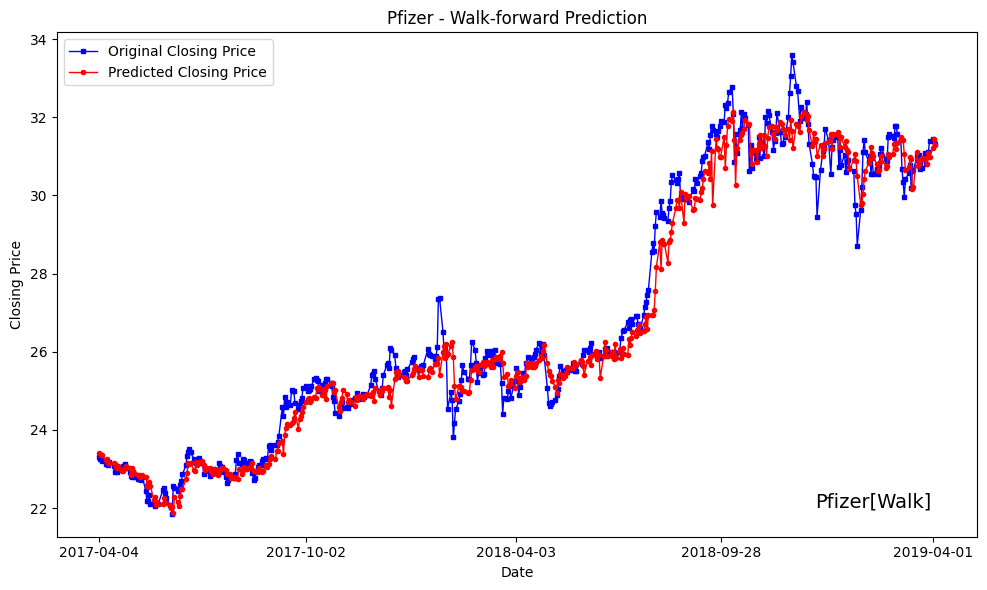

Model for Pfizer saved as Pfizer_best_model.pkl
Processing: JP Morgan Chase and Co
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
[JP Morgan Chase and Co] Progress: 50 / 503
[JP Morgan Chase and Co] Progress: 100 / 503
[JP Morgan Chase and Co] Progress: 150 / 503
[JP Morgan Chase and Co] Progress: 200 / 503
[JP Morgan Chase and Co] Progress: 250 / 503
[JP Morgan Chase and Co] Progress: 300 / 503
[JP Morgan Chase and Co] Progress: 350 / 503
[JP Morgan Chase and Co] Progress: 400 / 503
[JP Morgan Chase and Co] Progress: 450 / 503
[JP Morgan Chase and Co] Progress: 500 / 503

[JP Morgan Chase and Co] Walk-forward RMSE: 1.9474, MAPE: 0.0177, MBE: 0.2340


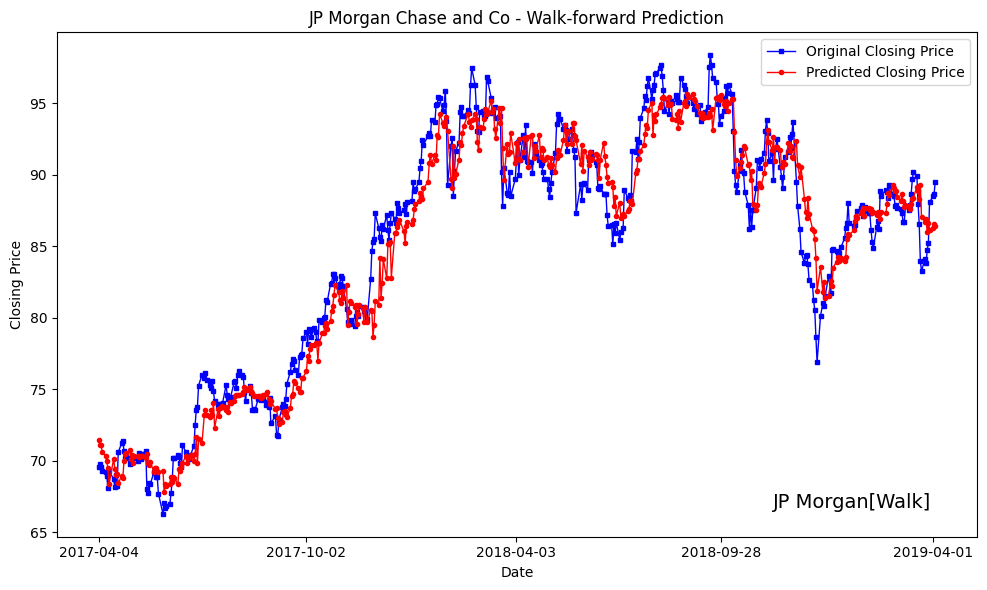

Model for JP Morgan Chase and Co saved as JP Morgan_best_model.pkl
Processing: Goldman Sachs
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
[Goldman Sachs] Progress: 50 / 503
[Goldman Sachs] Progress: 100 / 503
[Goldman Sachs] Progress: 150 / 503
[Goldman Sachs] Progress: 200 / 503
[Goldman Sachs] Progress: 250 / 503
[Goldman Sachs] Progress: 300 / 503
[Goldman Sachs] Progress: 350 / 503
[Goldman Sachs] Progress: 400 / 503
[Goldman Sachs] Progress: 450 / 503
[Goldman Sachs] Progress: 500 / 503

[Goldman Sachs] Walk-forward RMSE: 4.8525, MAPE: 0.0191, MBE: -0.3567


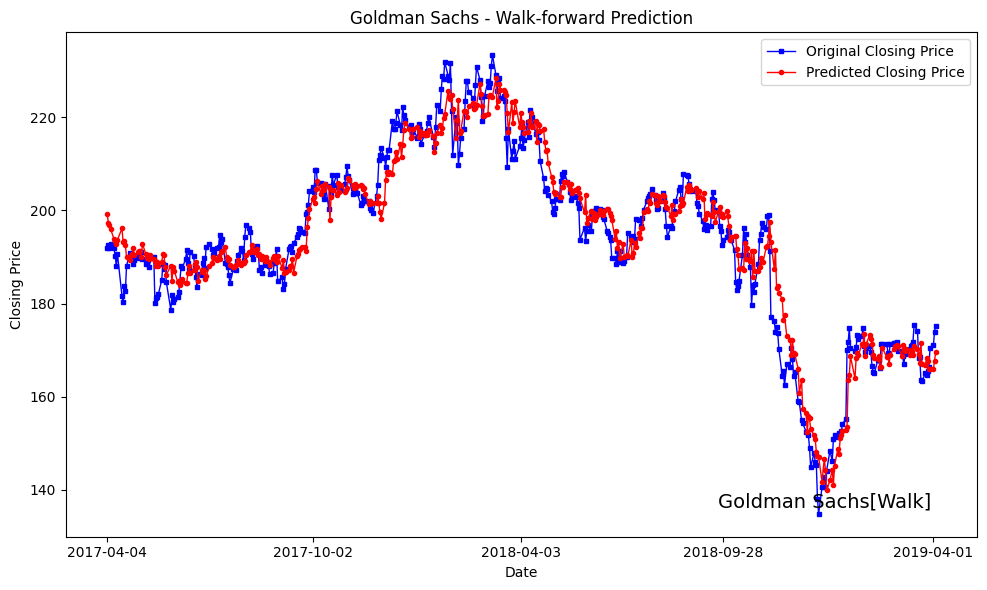

Model for Goldman Sachs saved as Goldman Sachs_best_model.pkl
Processing: Nike
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
[Nike] Progress: 50 / 503
[Nike] Progress: 100 / 503
[Nike] Progress: 150 / 503
[Nike] Progress: 200 / 503
[Nike] Progress: 250 / 503
[Nike] Progress: 300 / 503
[Nike] Progress: 350 / 503
[Nike] Progress: 400 / 503
[Nike] Progress: 450 / 503
[Nike] Progress: 500 / 503

[Nike] Walk-forward RMSE: 1.6264, MAPE: 0.0194, MBE: 0.4443


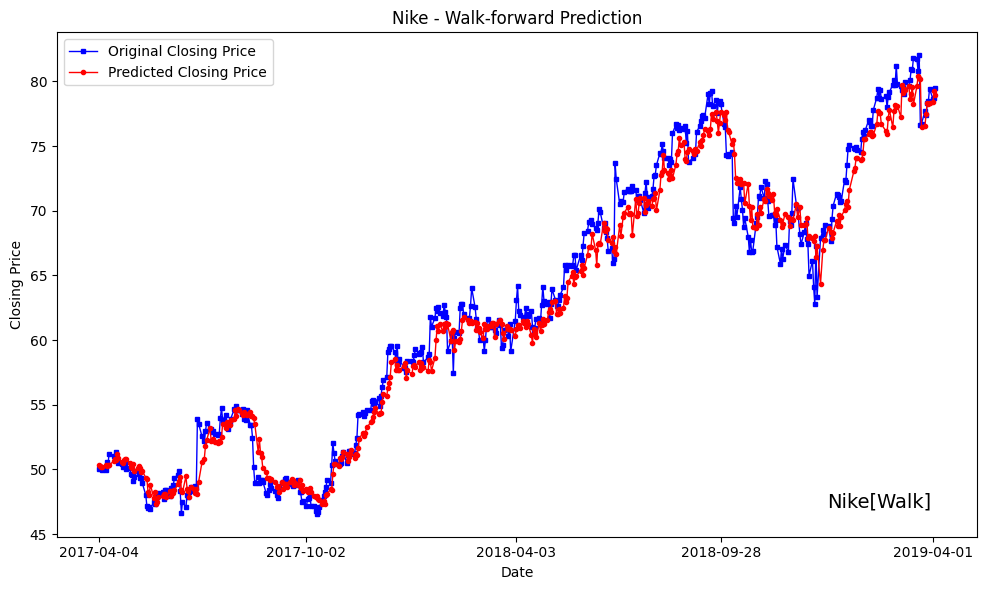

Model for Nike saved as Nike_best_model.pkl
Processing: Johnson and Johnson
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
[Johnson and Johnson] Progress: 50 / 503
[Johnson and Johnson] Progress: 100 / 503
[Johnson and Johnson] Progress: 150 / 503
[Johnson and Johnson] Progress: 200 / 503
[Johnson and Johnson] Progress: 250 / 503
[Johnson and Johnson] Progress: 300 / 503
[Johnson and Johnson] Progress: 350 / 503
[Johnson and Johnson] Progress: 400 / 503
[Johnson and Johnson] Progress: 450 / 503
[Johnson and Johnson] Progress: 500 / 503

[Johnson and Johnson] Walk-forward RMSE: 1.9883, MAPE: 0.0135, MBE: 0.3318


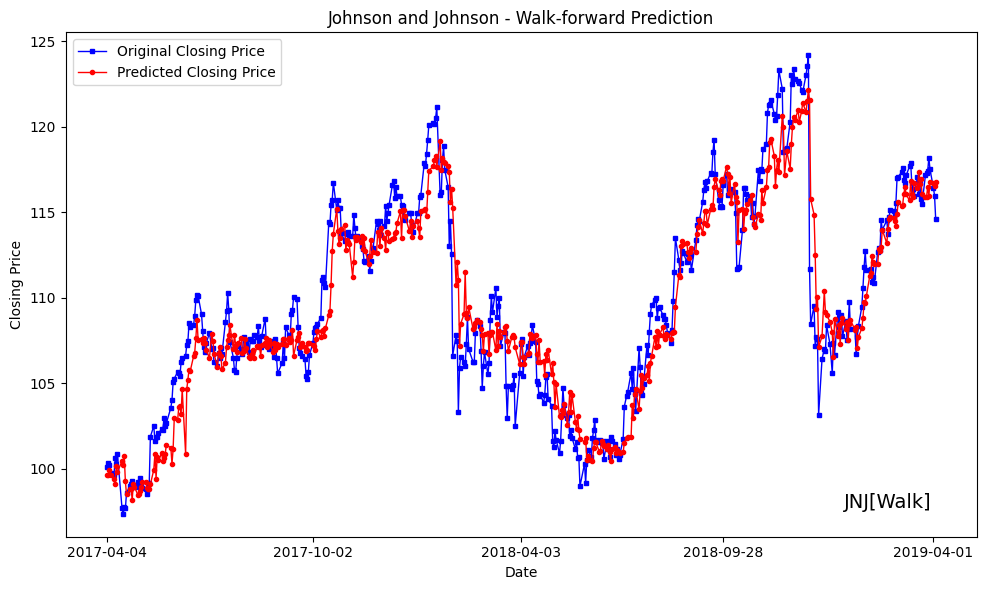

Model for Johnson and Johnson saved as JNJ_best_model.pkl


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import joblib

# Load data
def load_data(file_path):
    df = pd.read_excel(file_path, header=2)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Construction feature
def create_features(df):
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Close'] - df['Open']
    df['7_DAY_MA'] = df['Close'].rolling(window=7).mean()
    df['14_DAY_MA'] = df['Close'].rolling(window=14).mean()
    df['21_DAY_MA'] = df['Close'].rolling(window=21).mean()
    df['7_DAY_STD_DEV'] = df['Close'].rolling(window=7).std()
    df['Target'] = df['Close'].shift(-1)
    
    df = df.dropna(subset=[
        'H-L', 'O-C', '7_DAY_MA', '14_DAY_MA', '21_DAY_MA', '7_DAY_STD_DEV', 'Volume', 'Target', 'Date'
    ])
    return df

# Evaluation index calculation function
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mbe = np.mean(np.array(y_true) - np.array(y_pred))
    return rmse, mape, mbe

# Expanding Window Cross-Validation module
def expanding_window_predictor(
    df,
    features,
    target,
    model_cls=RandomForestRegressor,
    model_params=None,
    train_end_date='2017-04-03',
    company_name='Unknown',
    stock_code='stock',
    plot=True,
    verbose=True
):
    if model_params is None:
        model_params = {
            'n_estimators': 300,
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'n_jobs': -1,
            'random_state': 42
        }

    df = df.sort_values('Date').reset_index(drop=True)
    df = df.dropna(subset=features + [target, 'Date'])

    # Normalization
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    train_end = pd.Timestamp(train_end_date)
    train_indices = df[df['Date'] <= train_end].index
    if len(train_indices) == 0:
        raise ValueError("Training set is empty, please check train_end_date")

    initial_train_end = train_indices[-1]

    predictions = []
    actuals = []
    dates = []

    for i in range(initial_train_end + 1, len(df)):
        train_data = df.loc[:i-1]
        test_data = df.loc[i:i]

        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]

        model = model_cls(**model_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        predictions.append(y_pred)
        actuals.append(y_test.values[0])
        dates.append(test_data['Date'].values[0])

        if verbose and (i - initial_train_end) % 50 == 0:
            print(f"[{company_name}] Progress: {i - initial_train_end} / {len(df) - initial_train_end - 1}")

    rmse, mape, mbe = calculate_metrics(actuals, predictions)
    print(f"\n[{company_name}] Walk-forward RMSE: {rmse:.4f}, MAPE: {mape:.4f}, MBE: {mbe:.4f}")

    if plot:
        results = pd.DataFrame({
            'Date': dates,
            'Original Closing Price': actuals,
            'Predicted Closing Price': predictions
        })

        plt.figure(figsize=(10, 6))
        plt.plot(results['Date'], results['Original Closing Price'], 's-', label='Original Closing Price', color='blue', linewidth=1, markersize=3)
        plt.plot(results['Date'], results['Predicted Closing Price'], 'o-', label='Predicted Closing Price', color='red', linewidth=1, markersize=3)

        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'{company_name} - Walk-forward Prediction')
        plt.legend()
        plt.xticks(results['Date'][::125])
        plt.text(0.95, 0.05, stock_code + '[Walk]',
                 horizontalalignment='right',
                 verticalalignment='bottom',
                 transform=plt.gca().transAxes,
                 fontsize=14)
        plt.tight_layout()
        plt.savefig(f'./pictures/{stock_code}_walkforward.png')
        plt.show()

    return {
        'rmse': rmse,
        'mape': mape,
        'mbe': mbe,
        'predictions': predictions,
        'actuals': actuals,
        'dates': dates
    }

# Hyperparameter tuning with GridSearchCV
def tune_hyperparameters(df, features, target):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_search.fit(df[features], df[target])

    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_params_

file_paths = [
    './data/data/Pfizer_stock_data.xlsx',
    './data/data/JP Morgan Chase and Co_stock_data.xlsx',
    './data/data/Goldman Sachs_stock_data.xlsx',
    './data/data/Nike_stock_data.xlsx',
    './data/data/Johnson and Johnson_stock_data.xlsx'
]
    
# Main function to load data, create features, and run the predictor
def main():
    for index, file_path in enumerate(file_paths):
        company_name = file_path.split('/')[-1].split('_')[0]
        stock_code = ['Pfizer', 'JP Morgan', 'Goldman Sachs', 'Nike', 'JNJ'][index]
        print(f"Processing: {company_name}")

        df = load_data(file_path)
        df = create_features(df)

        features = ['H-L', 'O-C', '7_DAY_MA', '14_DAY_MA', '21_DAY_MA', '7_DAY_STD_DEV', 'Volume']

        # Hyperparameter tuning
        best_params = tune_hyperparameters(df, features, 'Target')

        # Run the predictor with best parameters
        result = expanding_window_predictor(
            df=df,
            features=features,
            target='Target',
            model_cls=RandomForestRegressor,
            model_params=best_params,
            train_end_date='2017-04-03',
            company_name=company_name,
            stock_code=stock_code,
            plot=True,
            verbose=True
        )

        # Save the best model
        model = RandomForestRegressor(**best_params)
        model.fit(df[features], df['Target'])
        joblib.dump(model, f'./models/{stock_code}_best_model.pkl')
        print(f"Model for {company_name} saved as {stock_code}_best_model.pkl")

if __name__ == "__main__":
    main()
